**Oblig2 ML Dat158 Playing the whole game**


(Niklas Johansson, Darren Bernardo, Per-Helge Litzheim, Hassan Ali Abdullahi)


1 Frame the problem and look at the big picture 

2 Get the data 

3 Explore the data to gain insights 

4 Prepare the data 

5 Explore many different models and short-list the best ones

6 Fine-tune your models and combine them into a great solution 

7 Present your solution 

8 Launch, monitor and maintain your system


**1. Framing the problem**

We have choosen to work with the box_office data set. Our objective is to learn more about the data and then prepare the data for deployment.



In [10]:
# All necessery imports in one place

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import lightgbm as lgb
import itertools
import ast
import eli5
import time
import seaborn as sns # prettier plotting

from scipy import stats

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.impute import SimpleImputer
from collections import Counter

import os
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight') # Prettier colors in plots


2 Get the data 

In [11]:
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
sample_submission = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

**3 Explore the data to gain insights**

We will not have a lot of fancy visualiztion, rather keep it short and focused.

In [12]:
# checking shape of data
shape = train.shape
train.shape, test.shape

((3000, 23), (4398, 22))

Unsure why the test set is larger than the train.. However that seams to be our smallest problem. Many of the columns are in JSON format, others like budget contains 0 values which are probably unknown rather.


In [13]:
train.budget.describe()

count    3.000000e+03
mean     2.253133e+07
std      3.702609e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+06
75%      2.900000e+07
max      3.800000e+08
Name: budget, dtype: float64

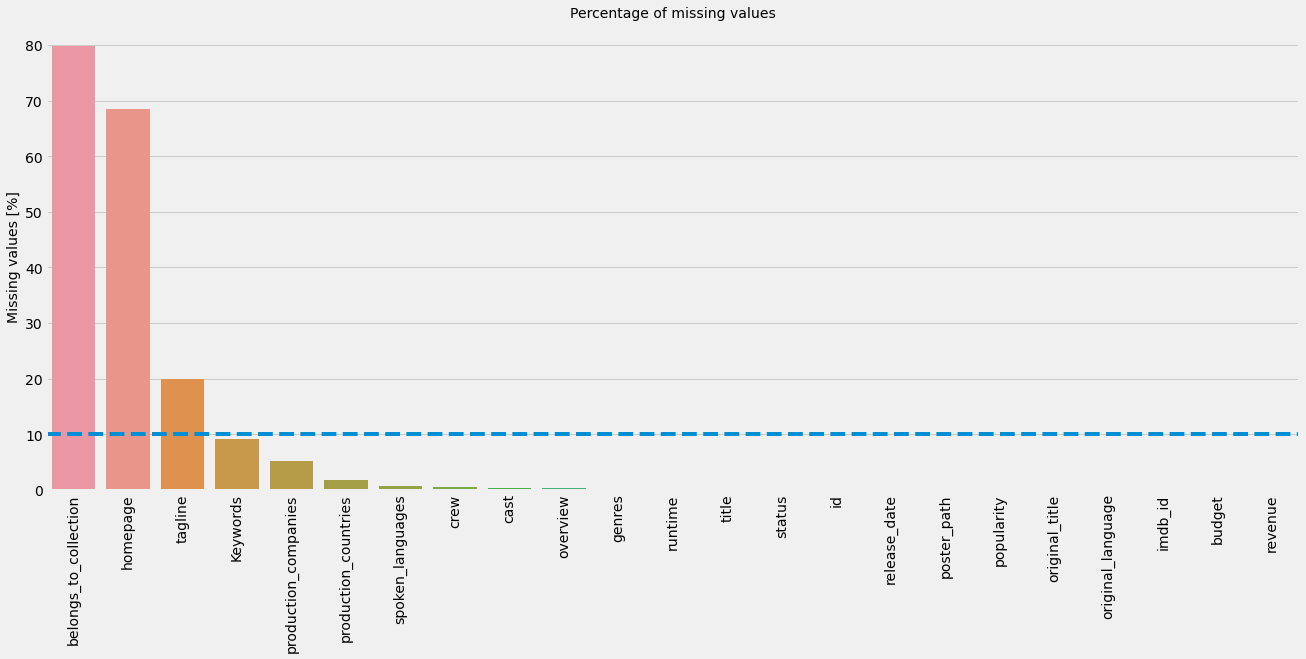

In [14]:
# calculate percentage of missing values
pct_nans = round(train.isnull().sum()/shape[0]*100,1).to_frame().sort_values(by=[0], ascending=False)
# create a bar chart
plt.figure(figsize=(20,8))
sns.barplot(x=pct_nans.index, y=pct_nans[0])
plt.axhline(10, ls="--")
plt.xticks(rotation=90, fontsize=14)
plt.title("Percentage of missing values", fontsize=14)
plt.ylabel("Missing values [%]", fontsize=14)
plt.show()

**4. Preparing the data**

Time to fix the things that needed fixing, a lot of cleaning needed:

In [15]:
# Found some of the missing values from budget/revenue in the notebook: EDA, Feature Engineering, LGB+XGB+CAT (Kamal Chhirang, has written that he himsel took from others)
# https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat

train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30


In [16]:
# method for encoding str columns to int

def lab_encode(df):
    for col in ['production_countries', 'all_genres', 'original_language' ]:
        df[col]= LabelEncoder().fit_transform(df[col]) 
    

In [17]:
# To make the deployment as painless as possible we reduce the numbers of columns.
# 

class Preprocessor(BaseEstimator,TransformerMixin):
    
    def fit(self,df,y=None):
            return self
    
    def transform(self,df, y=None):
            #Changeing release date to Year and Month, also changeing release years from future dates to correct(ie. 2068 to 1968)
            df['release_date'] = pd.to_datetime(df['release_date'])
            df['release_year'] = df['release_date'].dt.year
            df['release_month'] = df['release_date'].dt.month
            df['release_year']=np.where(df['release_year']> 2018, df['release_year']-100, df['release_year']) 
            
            df['budget_year_ratio'] = df['budget'] / (df['release_year'] * df['release_year'])
            
            df['genres']=df['genres'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
            df['all_genres'] = df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
            
            df["tagline"] = df.tagline.isnull() # Only keeping if the movie has a tagline or not
            df["tagline"] = df.tagline.astype("int32")

            df["belongs_to_collection"] = df.belongs_to_collection.isnull()
            df["belongs_to_collection"] = df.belongs_to_collection.astype("int32")
            
            df['production_countries']=df['production_countries'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
            df['production_countries']= df['production_countries'].apply(lambda x: ' '.join(sorted([i['iso_3166_1'] for i in x])) if x != {} else '')
            
            lab_encode(df) # calling the above method
            
            df.drop(columns=['release_date', "imdb_id"], inplace=True)
            df.drop(columns=["poster_path"], inplace=True)
            df.drop(columns=["status"], inplace=True)
            df.drop(columns=["overview"], inplace=True)
            df.drop(columns=["original_title"], inplace=True)
            df.drop(columns=["spoken_languages"], inplace=True)
            df.drop(columns=["Keywords"], inplace=True)
            df.drop(columns=['production_companies'], inplace=True)
            df.drop(columns=["title"], inplace=True)  
            df.drop(columns=['crew'], inplace=True)
            df.drop(columns=['genres'], inplace=True)
            df.drop(columns=['cast'], inplace=True)
            df.drop(columns=['homepage'], inplace=True)
            df.drop(columns=['id'], inplace=True)
            return df

In [18]:
train = Preprocessor().fit_transform(train)
test = Preprocessor().transform(test)

In [28]:
# checking how the train data correlates to label(revenue)
corr_matrix = train.corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue                  1.000000
budget                   0.755986
budget_year_ratio        0.755321
popularity               0.461522
runtime                  0.216652
release_year             0.137861
production_countries     0.067025
release_month            0.020557
original_language       -0.092216
tagline                 -0.180229
all_genres              -0.245050
belongs_to_collection   -0.338683
Name: revenue, dtype: float64

In [29]:
# Here is where we're done with this process we store the processed train set and its labels for further use
labels = train["revenue"].copy() 
X=train.drop(["revenue"], axis=1)

y = np.log1p(train['revenue'])

In [ ]:
# X.to_csv('pp_train.csv', index=False)
# y.to_csv('pp_labels.csv', index=False)

**5 & 6 Explore models and Fine-tuning them**

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold

# pipeline for scaling and imputing

pipeline = Pipeline([
    ("Rbt_scaler", RobustScaler()),
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

prepared = pipeline.fit_transform(X, y)
pretest = pipeline.transform(test)

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [31]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.4409	valid_1's rmse: 2.07334
Early stopping, best iteration is:
[1226]	training's rmse: 1.384	valid_1's rmse: 2.06842


Weight,Feature
0.4074,budget_year_ratio
0.1641,popularity
0.1292,budget
0.0945,release_year
0.0509,runtime
0.0501,all_genres
0.0365,production_countries
0.0242,release_month
0.0176,belongs_to_collection
0.0153,original_language


Looks good! The only thing that worries me a bit is if we keep both budget and budget to year ratio the prediction will be "budget heavy".

In [32]:
Random_Search_Params ={
    "max_depth": [4],
    "min_data_in_leaf": [15],
    'learning_rate': [0.01],
    'num_leaves': [40],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'random_state' : [501], 
    }

n_HP_points_to_test = 50

random_search = RandomizedSearchCV(
    estimator=lgb_model, param_distributions= Random_Search_Params, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

random_search.fit(X, y)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

# Using parameters already set above, replace in the best from the random search

params['learning_rate'] = random_search.best_params_['learning_rate']
params['max_depth'] = random_search.best_params_['max_depth']
params['num_leaves'] = random_search.best_params_['num_leaves']


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.4s finished


Best score reached: 0.5460315736640616 with params: {'random_state': 501, 'objective': 'regression', 'num_leaves': 40, 'min_data_in_leaf': 15, 'max_depth': 4, 'learning_rate': 0.01, 'boosting_type': 'gbdt'} 


In [ ]:
final_model = random_search.best_estimator_
final_predict = final_model.predict(test)
len(final_predict)

In [ ]:
sample_submission['revenue']= np.expm1(final_predict)
sample_submission.to_csv('finalllly_sub.csv', index=False)